# Стахостическая модель хищник-жертва

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing as mp
import sde
import rungekutta
%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (13.0, 6.0)
rcParams['font.size'] = 18

Стохастическая модель Хищник-Жертва задается вектором сноса $A$ и матрицей диффузии $B$ следующего вида:
\begin{equation}
    A(x,y) = 
    \left(
        \begin{array}{c}
        k_{1}ax - k_{2}xy\\
        k_{2}xy - k_{3}y
        \end{array}
    \right)
    \qquad
    B(x,y) = 
    \left(
        \begin{array}{c}
        k_{1}ax+k_{2}xy & -k_{2}xy\\
        -k_{2}xy & k_{2}xy + k_{3}y
        \end{array}
    \right)
\end{equation}
здесь 

- $x$ --- жертвы,
- $y$ --- хищники,
- $a$ --- *рост жертв*,
- $k_{1}$ --- *конкуренцию жертв*,
- $k_{2}$ --- *частоту хищничества*,
- $k_{3}$ --- *смертность хищников*.

Зададим вначале параметры, а потом определим функции $A(x,y)$ и $B(x,y)$

In [3]:
a, k1, k2, k3 = (0.5, 3.0, 0.05, 2.5)
#a, k1, k2, k3 = (0.2, 3.0, 2.5, 10.85)

На их основе вычисляем стационарную точку $M_{2}$ детерминированной модели

In [4]:
M1 = (0.0,0.0)
M2 = (k3/k2, a*k1/k2)
print("\rСтационарная точка M2 = {0}".format(M2))

Стационарная точка M2 = (50.0, 30.0)


Начальные значения задаем как небольшое отклонение от стационарной точки

In [5]:
x_0 = (M2[0]+0.1, M2[1]-20.0)
print("Начальные значения: \n\t число жертв xo = {0[0]}\n\t число хищников yo = {0[1]}".format(x_0))

Начальные значения: 
	 число жертв xo = 50.1
	 число хищников yo = 10.0


Задаем необходимые функции. Вычисление квадратного корня из матрицы делаем с помощью SVD разложения, так как стандартная функция из библиотеки `scipy` сбоит.

\begin{equation}
    I(x,y) = k_{2}(x+y) - k_{3}\ln(x) - ak_{1}\ln(y)
\end{equation}

\begin{equation}
    \langle \mathrm{d}I(x,y) \rangle = \frac12 \left\langle \frac{ak_{1}k_{3}}{x} + \frac{k_{2}k_{3}y}{x} + \frac{ak_{1}k_{2}x}{y} + \frac{ak_{1}k_{3}}{y} \right\rangle
\end{equation}

In [6]:
def matrix_sqrt(M):
    U, s, V = np.linalg.svd(M, full_matrices=True)
    S = np.diag(s)
    return np.dot(U, np.dot(np.sqrt(S), V))
def f(x):
    """Вектор сноса"""
    return np.array([k1*a*x[0] - k2*x[0]*x[1], k2*x[0]*x[1] - k3*x[1]])

def detf(t,x,p):
    """Правая часть детерминированной ОДУ
    (метод требует функцию с тремя аргументами t, x, p)"""
    return f(x)

def G(x):
    """Матрица диффузии"""
    return matrix_sqrt(np.array([[x[0]*(k1*a + k2*x[1]), -k2*x[0]*x[1]],
                           [-k2*x[0]*x[1], x[1]*(k2*x[0] + k3)]]))

def I(x):
    return k2*(x[0] + x[1]) - k3*np.log(x[0]) - k1*a*np.log(x[1])

def Istoch(x):
    return 0.5*(a*k1*k3/x[0] + k2*k3*x[1]/x[0] + a*k1*k2*x[0]/x[1] + k1*k3/x[1])

Генерируем траекторию процесса Винера из `N` шагов:

In [7]:
t_0 = 0.0
T = 20.0
N = 10**3

In [8]:
(dt, t, dW, W) = sde.wiener_process(N, dim=2, interval=(t_0, T))

Решаем детерминированную систему

In [9]:
RK = rungekutta.RK(2)
x_num_det, y_num_det = RK.integrate(detf, x_0, time_interval=(0.0, T), h=dt)[1]

In [10]:
x_num_stoch, y_num_stoch = sde.weakRK22W2(f, G, dt, x_0, dW).T
#x_num_stoch, y_num_stoch = sde.strongSRKp1Wm1(f, G, dt, x_0, dW).T
while len(x_num_stoch) < N:
    (dt, t, dW, W) = sde.wiener_process(N, dim=2, interval=(t_0, T))
    x_num_stoch, y_num_stoch = sde.weakRK22W2(f, G, dt, x_0, dW).T
    #x_num_stoch, y_num_stoch = sde.strongSRKp1Wm1(f, G, dt, x_0, dW).T
    print(len(x_num_stoch), end=", ")
#x_num_stoch, y_num_stoch = sde.EulerMaruyamaWm(f, G, dt, x_0, dW).T

416, 197, 640, 927, 207, 1000, 

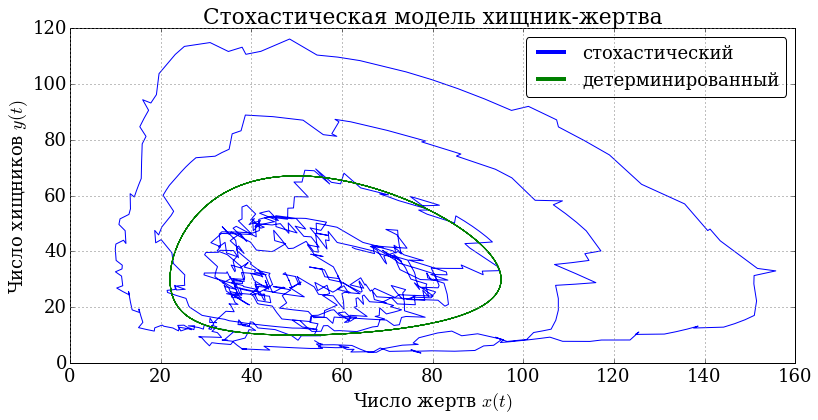

In [11]:
fig0 = plt.figure(0)
ax0 = fig0.add_subplot(1,1,1)
ax0.set_title("Стохастическая модель хищник-жертва")
ax0.set_xlabel("Число жертв $x(t)$")
ax0.set_ylabel("Число хищников $y(t)$")
ax0.plot(x_num_stoch, y_num_stoch, label='стохастический')
ax0.plot(x_num_det, y_num_det, label='детерминированный')

ax0.legend()
# для утолщения линии в легенде
for line in ax0.get_legend().get_lines():
    line.set_linewidth(4.0)

In [12]:
print("Число элементов в массивах:\n x_num_stoch: {0}\n x_num_det: {1}\n t: {2}".format(len(x_num_stoch),
                                                                                        len(x_num_det),
                                                                                        len(t)))

Число элементов в массивах:
 x_num_stoch: 1000
 x_num_det: 1001
 t: 1000


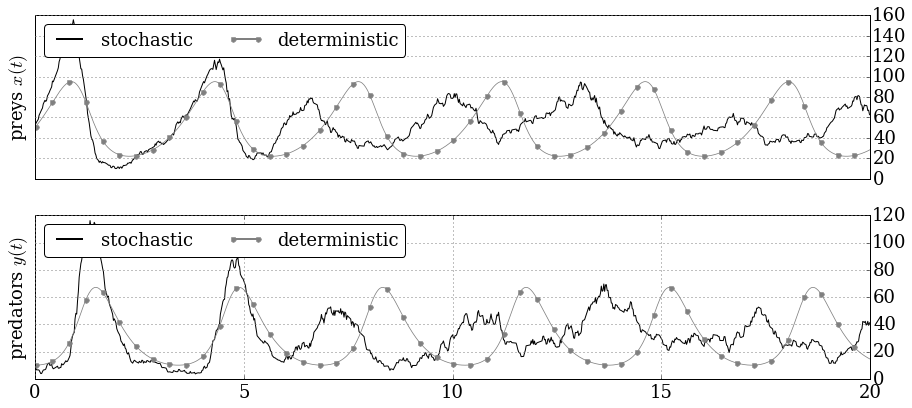

In [13]:
l = len(x_num_stoch)
fig1 = plt.figure(1)
ax1 = [fig1.add_subplot(2,1,1), fig1.add_subplot(2,1,2)]
# Стохастическое решение
ax1[0].plot(t[:l], x_num_stoch, color='k', lw=1.0, label='stochastic')
ax1[1].plot(t[:l], y_num_stoch, color='k', lw=1.0, label='stochastic')
# Детерминированное решение
ax1[0].plot(t[:], x_num_det[1:], color='gray', lw=0.75, label='deterministic', mfc='gray', marker='.', ms=10, markevery=20)
ax1[1].plot(t[:], y_num_det[1:], color='gray', lw=0.75, label='deterministic', mfc='gray', marker='.', ms=10, markevery=20)

ax1[0].set_ylabel("preys $x(t)$")
ax1[1].set_ylabel("predators $y(t)$")

ax1[0].xaxis.set_visible(False)
ax1[0].yaxis.tick_right()
ax1[1].yaxis.tick_right()

[ax1[i].legend(framealpha=1, ncol=2, loc='upper left') for i in [0,1]]
# для утолщения линии в легенде
for line in ax1[0].get_legend().get_lines():
    line.set_linewidth(2.0)
for line in ax1[1].get_legend().get_lines():
    line.set_linewidth(2.0)

fig1.tight_layout()

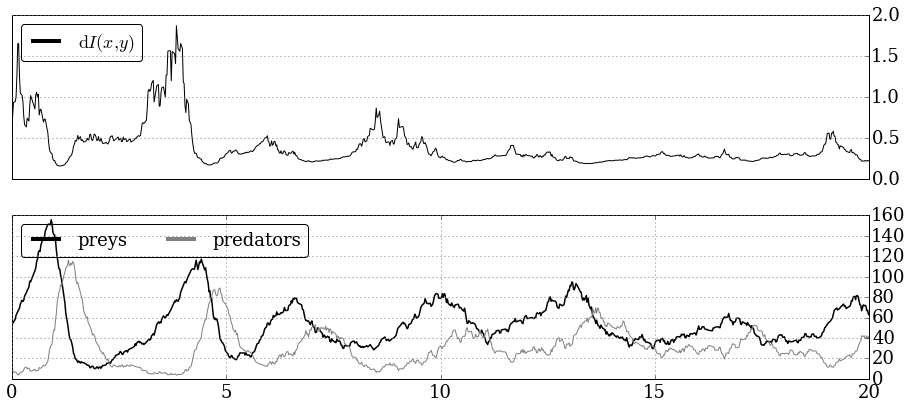

In [14]:
fig2 = plt.figure(2)
ax21 = fig2.add_subplot(2,1,1)
ax22 = fig2.add_subplot(2,1,2)

#ax2.plot(t[:], I([x_num_det[1:], y_num_det[1:]]), color='r', lw=2.0, label='$I$')
ax21.plot(t[:l], Istoch([x_num_stoch[:], y_num_stoch[:]]), color='k', lw=1.0, label=r'$\mathrm{d}I(x,y)$')

# Стохастическое решение
ax22.plot(t[:l], x_num_stoch, color='k', lw=1.5, label="preys")
ax22.plot(t[:l], y_num_stoch, color='gray', lw=1.0, ls='-', label="predators")

ax21.xaxis.set_visible(False)
ax21.yaxis.tick_right()
ax22.yaxis.tick_right()

ax21.set_ylabel("")

ax21.legend(loc='upper left', ncol=2)
ax22.legend(loc='upper left', ncol=2)

# для утолщения линии в легенде
for line in ax21.get_legend().get_lines():
    line.set_linewidth(4.0)
for line in ax22.get_legend().get_lines():
    line.set_linewidth(4.0)
fig2.tight_layout()

## Численные эксперементы

In [15]:
# proc_num --- число процессов
# sim_num --- число симуляций
proc_num = 4
sim_num = 500
#%run prepre_parallel.py proc_num sim_num
x1_nums = np.load("Результат 500 прогонов Жертвы.npy")
x2_nums = np.load("Результат 500 прогонов Хищники.npy")

## Статистические характеристики полученной выборки

Вычисляем эмпирические моменты (выборочное среднее $\mathrm{E}[x]$ и второй момент $\mathrm{E}[x^2]$):
\begin{equation}
    \langle x \rangle = \mathrm{E}[x] = \frac{1}{n}\sum\limits^{n}_{i=1}x_{i},\quad \mathrm{E}[x^2] = \frac{1}{n}\sum\limits^{n}_{i=1}x^2_{i}
\end{equation}
и эмпирическую дисперсию:
\begin{equation}
    \mathrm{D}[x] = \frac{1}{n}\sum\limits^{n}_{i=1}(x_{i} - \mathrm{E}[x_{i}])^2
\end{equation}

- *0,25-квантиль* $Q_{0.25}$ называется **первым (или нижним)** квартилем (от лат. quarta — четверть);
- *0,5-квантиль* $M$ называется **медианой** (от лат. mediāna — середина) или вторым квартилем;
- *0,75-квантиль* $Q_{0.75}$ называется **третьим (или верхним)** квартилем.


In [16]:
median = [np.median(x1_nums, axis=0), np.median(x2_nums, axis=0)]
moment_1  = [np.mean(x1_nums, axis=0), np.mean(x2_nums, axis=0)]
moment_2  = [np.mean(x1_nums**2, axis=0), np.mean(x2_nums**2, axis=0)]
Var = [np.mean((x1_nums - moment_1[0])**2, axis=0), np.mean((x2_nums - moment_1[1])**2, axis=0)]
Q1, Q3, Q95, Q5, Q100, Q0 = np.percentile(x1_nums, (25, 75, 95, 5, 100, 0), axis=0)

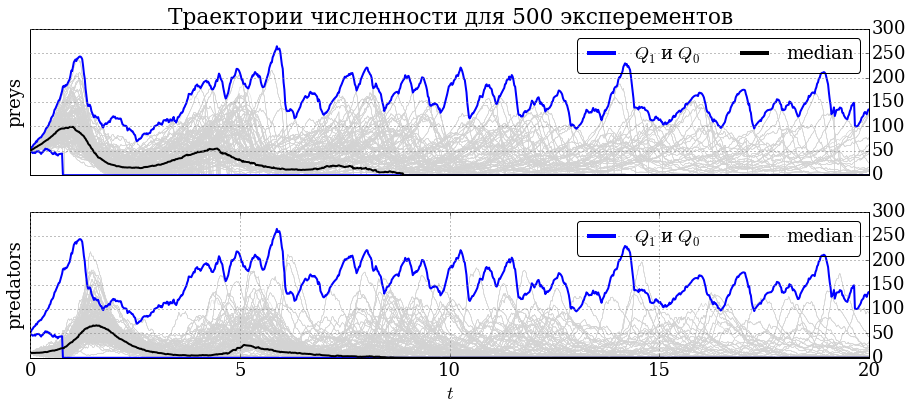

In [17]:
fig3 = plt.figure(3)
ax3 = [fig3.add_subplot(2,1,1), fig3.add_subplot(2,1,2)]

ax3[0].set_title("Траектории численности для {0} эксперементов".format(sim_num))

ax3[1].set_xlabel("$t$")
ax3[0].set_ylabel(r"preys")
ax3[1].set_ylabel(r"predators")

ax3[0].xaxis.set_visible(False)

for num in range(500):
    ax3[0].plot(t, x1_nums[num, :], color='lightgray', lw=0.4)
    ax3[1].plot(t, x2_nums[num, :], color='lightgray', lw=0.4)
    
#ax3[0].plot(t, Q1, color='r', label=r'$Q_{0.25}$ и $Q_{0.75}$', lw = 2.0)
#ax3[0].plot(t, Q3, color='r', lw = 2.0)

#ax3[0].plot(t, Q95, color='g', label=r'$Q_{0.95}$ и $Q_{0.05}$', lw = 2.0)
#ax3[0].plot(t, Q5, color='g', lw = 2.0)

ax3[0].plot(t, Q100, color='b', label=r'$Q_{1}$ и $Q_{0}$', lw = 2.0)
ax3[0].plot(t, Q0, color='b', lw = 2.0)
ax3[1].plot(t, Q100, color='b', label=r'$Q_{1}$ и $Q_{0}$', lw = 2.0)
ax3[1].plot(t, Q0, color='b', lw = 2.0)

ax3[0].plot(t, median[0], color='k', label='median', lw = 2.0)
ax3[1].plot(t, median[1], color='k', label='median', lw = 2.0)

ax3[0].yaxis.tick_right()
ax3[1].yaxis.tick_right()

ax3[0].legend(ncol=4, loc='upper right', framealpha=None)
for line in ax3[0].get_legend().get_lines():
    line.set_linewidth(4.0)
    
ax3[1].legend(ncol=4, loc='upper right', framealpha=None)
for line in ax3[1].get_legend().get_lines():
    line.set_linewidth(4.0)
fig3.tight_layout()

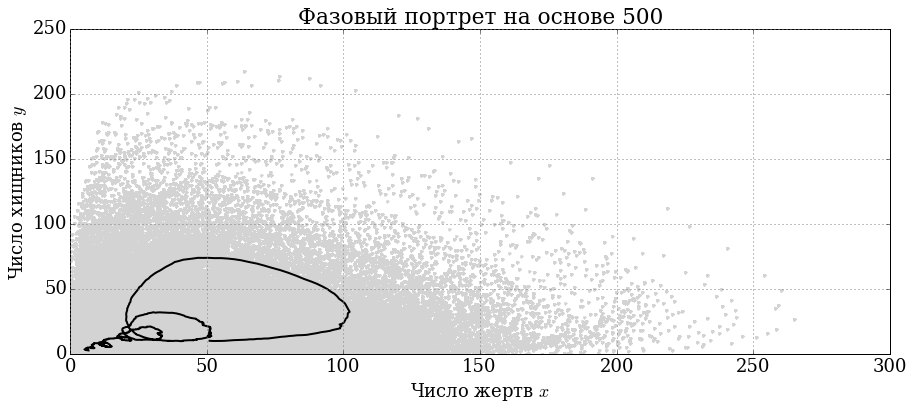

In [18]:
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(1,1,1)

ax4.set_xlabel("Число жертв $x$")
ax4.set_ylabel("Число хищников $y$")
ax4.set_title("Фазовый портрет на основе {0}".format(sim_num))

#ax4.plot(np.min(x1_nums, axis=0), np.min(x2_nums, axis=0))
#ax4.plot(np.max(x1_nums, axis=0), np.max(x2_nums, axis=0))
for num in range(500):
    ax4.plot(x1_nums[num, :], x2_nums[num, :], color='lightgray', lw=0.5, linestyle='None', marker='.')

ax4.plot(moment_1[0], moment_1[1], lw=2, color='k')
fig4.tight_layout()

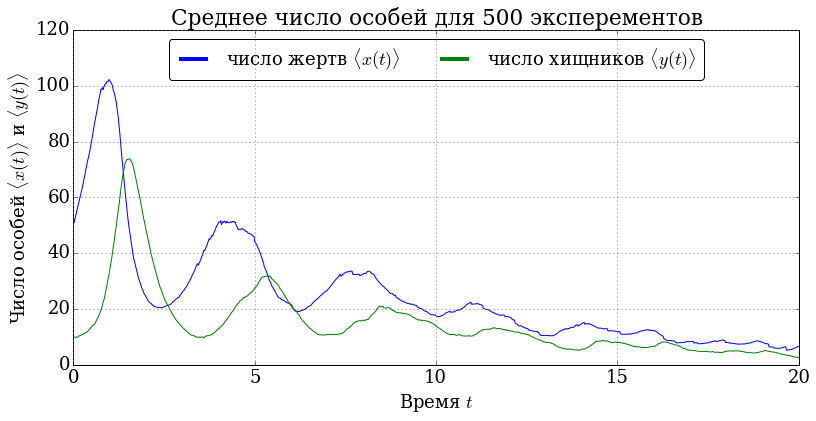

In [27]:
fig41 = plt.figure(41)
ax41 = fig41.add_subplot(1,1,1)
ax41.set_xlabel("Время $t$")
ax41.set_ylabel(r"Число особей $\langle x(t) \rangle$ и $\langle y(t)\rangle$")
ax41.set_title("Среднее число особей для {0} эксперементов".format(sim_num))

ax41.plot(t, moment_1[0], label=r"число жертв $\langle x(t) \rangle$")
ax41.plot(t, moment_1[1], label=r"число хищников $\langle y(t) \rangle$")

ax41.legend(ncol=3, loc='upper center', framealpha=None)
for line in ax41.get_legend().get_lines():
    line.set_linewidth(4.0)

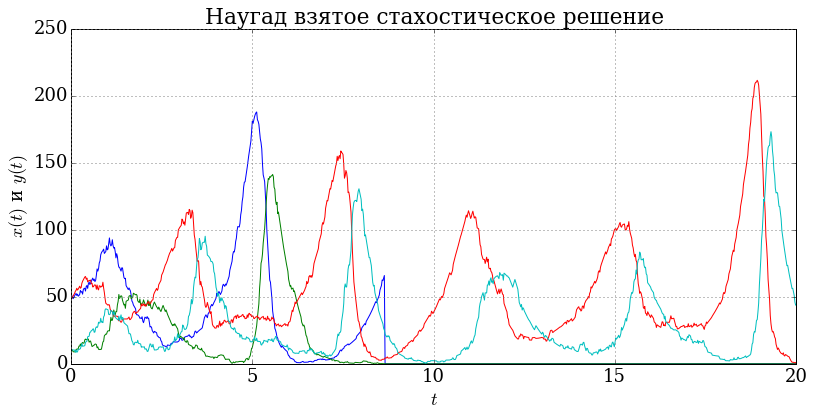

In [20]:
fig42 = plt.figure(42)
ax42 = fig42.add_subplot(1,1,1)

ax42.set_title("Наугад взятое стахостическое решение")
ax42.set_xlabel("$t$")
ax42.set_ylabel("$x(t)$ и $y(t)$")

ax42.plot(t, x1_nums[0])
ax42.plot(t, x2_nums[0])

ax42.plot(t, x1_nums[123])
ax42.plot(t, x2_nums[123])

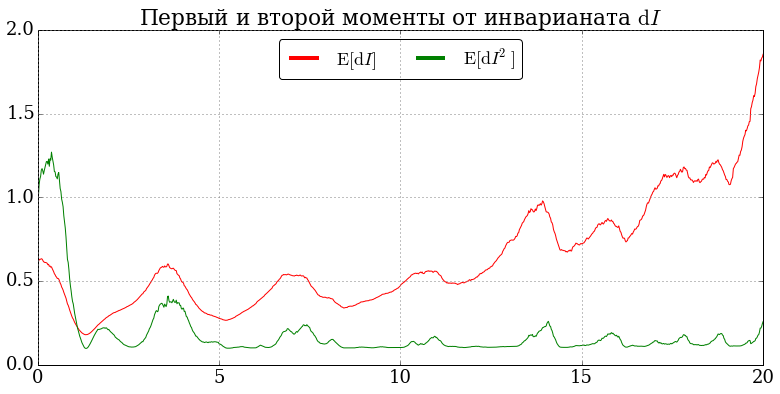

In [21]:
Q95s = [np.percentile(x1_nums, 95, axis=0), np.percentile(x2_nums, 95, axis=0)]
Q05s = [np.percentile(x1_nums, 5, axis=0), np.percentile(x2_nums, 5, axis=0)]

fig5 = plt.figure(5)
ax5 = fig5.add_subplot(1, 1, 1)
ax5.set_title(r"Первый и второй моменты от инварианата $\mathrm{d}I$")

ax5.plot(t, Istoch(moment_1), color='r', label=r"$\mathrm{E}[\mathrm{d}I]$")
ax5.plot(t, Istoch(moment_2), color='g', label=r"$\mathrm{E}[\mathrm{d}I^2]$")
#ax5.plot(t, Istoch(Var), color='g', label=r"$\mathrm{D}[\mathrm{d}I^2]$")

#ax5.plot(t, Istoch(Q95s), color='g', label=r'$Q_{0.95}(\mathrm{d}I)$')
#ax5.plot(t, Istoch(Q05s), color='b', label=r'$Q_{0.05}(\mathrm{d}I)$')

ax5.legend(ncol=3, loc='upper center', framealpha=None)
for line in ax5.get_legend().get_lines():
    line.set_linewidth(4.0)

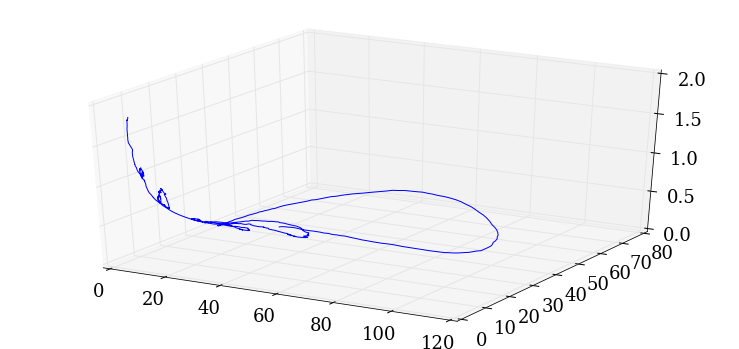

In [24]:
fig6 = plt.figure(60)
ax6 = fig6.add_subplot(1, 1, 1, projection='3d')
ax6.plot(moment_1[0], moment_1[1], Istoch(moment_1))